# Examining fits of neurons in the brain-wide map

First let's do some data I/O, loading in our fits from a given date and looking at the distribution of D^2 scores by session:

In [33]:
from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
from tqdm import tqdm
import brainbox.io.one as bbone

%matplotlib inline
fitdate = '2021-09-27'
fitpath = '/home/berk/Documents/fits/'
fitfiles = [fitpath + f'{subjdir}/{file}'
            for subjdir in os.listdir(fitpath) 
            for file in os.listdir(fitpath + subjdir)
            if re.match(f'.*{fitdate}.*poststim_pseudosess_fit\.p', file)]
filedata = {}
for filename in fitfiles:
    data = np.load(filename, allow_pickle=True)
    data['clu_regions'] = data['fitobj'].clu_regions.copy()
    _ = data.pop('fitobj')
    filedata[filename] = data


In [34]:
%connect_info

{
  "shell_port": 47517,
  "iopub_port": 35979,
  "stdin_port": 41593,
  "control_port": 60649,
  "hb_port": 52669,
  "ip": "127.0.0.1",
  "key": "c6f11d12-298602f51fede7d38b330cd6",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-8235b72a-611b-4b31-a399-4f317dc8cd6b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [35]:
observed_regions = []
for key, ses in filedata.items():
    unitdf = pd.Series(ses['clu_regions'][ses['realscores'].index],
                       index=ses['realscores'].index, name='acronym')
    unitdf.index = unitdf.index.rename('cluster_id')
    ses['unit_regions'] = unitdf
    observed_regions.extend(unitdf.unique())
allregions = list(set(observed_regions))
print(len(filedata), len(allregions))


281 460


In [36]:
for key, ses in filedata.items():
    scoresdf = filedata[key]['realscores']
    scoresdf.name = 'baseline'
    for i, scores in enumerate(ses['scores']):
        scoresdf = pd.concat([scoresdf, scores.rename('run' + str(i))], axis=1)
    ses['scoresdf'] = scoresdf

In [37]:
from ibllib.atlas import BrainRegions
from ibllib.atlas import AllenAtlas
from scipy.stats import percentileofscore, zscore
from iblutil.numerical import ismember

CLEANUP = True

sess_strs = {s['sessinfo']['nickname'] + ' from ' +
             s['sessinfo']['sessdate'] + ' probe: ' +
             fn[fn.find('probe') + 5] : fn for fn, s in filedata.items()}
orig_fns = list(filedata.keys())
masterscores = []
for i, fn in enumerate(list(filedata.keys())):
    scores = filedata[fn]['scoresdf'].copy()
    regions = filedata[fn]['unit_regions']
    scores['acronym'] = regions
    scores['eid'] = filedata[fn]['sessinfo']['eid']
    try:
        scores['probe'] = filedata[fn]['probe']
    except KeyError:
        pix = fn.find('probe')
        scores['probe'] = fn[pix: pix + 7]
    scores = scores[pd.notna(scores['acronym'])]
    masterscores.append(scores)
    if CLEANUP:
        _ = filedata.pop(fn)
masterscores = pd.concat(masterscores)

brainregions = BrainRegions()
def remap(ids, source='Allen', dest='Beryl', output='acronym'):
    br = brainregions
    _, inds = ismember(ids, br.id[br.mappings[source]])
    ids = br.id[br.mappings[dest][inds]]
    if output == 'id':
        return br.id[br.mappings[dest][inds]]
    elif output == 'acronym':
        return br.get(br.id[br.mappings[dest][inds]])['acronym']

def get_id(acronym):
    return brainregions.id[np.argwhere(brainregions.acronym == acronym)[0, 0]]

def get_name(acronym):
    if acronym == 'void':
        return acronym
    reg_idxs = np.argwhere(brainregions.acronym == acronym).flat
    return brainregions.name[reg_idxs[0]]

def label_cerebellum(acronym):
    regid = brainregions.id[np.argwhere(brainregions.acronym == acronym).flat][0]
    ancestors = brainregions.ancestors(regid)
    if 'Cerebellum' in ancestors.name or 'Medulla' in ancestors.name:
        return True
    else:
        return False

def zsc_cell(unit):
    return zscore(np.append(unit.loc['run0':'run99'].astype(float), unit.loc['baseline']))[-1]

grpby = masterscores.groupby('acronym')
masterscores['reg_id'] = grpby.acronym.transform(lambda g: get_id(g.unique()[0]))
masterscores['beryl_acr'] = grpby.reg_id.transform(lambda g: remap(g))
masterscores['cerebellum'] = grpby.acronym.transform(lambda g: label_cerebellum(g.unique()[0]))
masterscores['percentile'] = masterscores.apply(lambda unit: percentileofscore(unit.loc
                                                ['run0':'run99'], unit['baseline']), axis=1)
masterscores['diff_95perc'] = masterscores['baseline'] - np.percentile(masterscores.loc[:,
    'run0':'run99'], 95, axis=1)
masterscores['name'] = grpby.beryl_acr.transform(lambda g: get_name(g.unique()[0]))

masterscores = masterscores.reset_index().rename(columns={'index':'clu_id'})
masterscores['zsc'] = masterscores.apply(zsc_cell, axis=1)

deltascores = pd.melt(masterscores,
                      id_vars=['baseline', 'eid', 'probe', 'clu_id', 'acronym', 'name', 'reg_id',
                               'beryl_acr', 'cerebellum', 'zsc'])
deltascores['diff'] = deltascores['baseline'] - deltascores['value']
masterscores['significant'] = masterscores['percentile'] >= 95

## Looking at fit characteristics by region

Next we would like to investigate the characteristics of single-neuron fits, conditioned by region. First, we will look at the $D^2$ (also known as pseudo-$R^2$) scores by region. We want to know for a given region:

1. What proportion of cells have a given kernel as the argmax for single-kernel $D^2$ scores, and what the distribution of scores for that kernel are given that it is the argmax kernel

2. Conditioned on a given first kernel, what the addtional explainability ($\Delta D^2$) is for each of the subsequent kernel options

In [ ]:
grouper = 'name'
min_neurons = 80
min_significant = 10

topregions = masterscores[grouper].value_counts()
topregions = topregions[topregions > min_neurons]

topreg_master = masterscores[np.isin(masterscores[grouper], topregions.index)].copy()

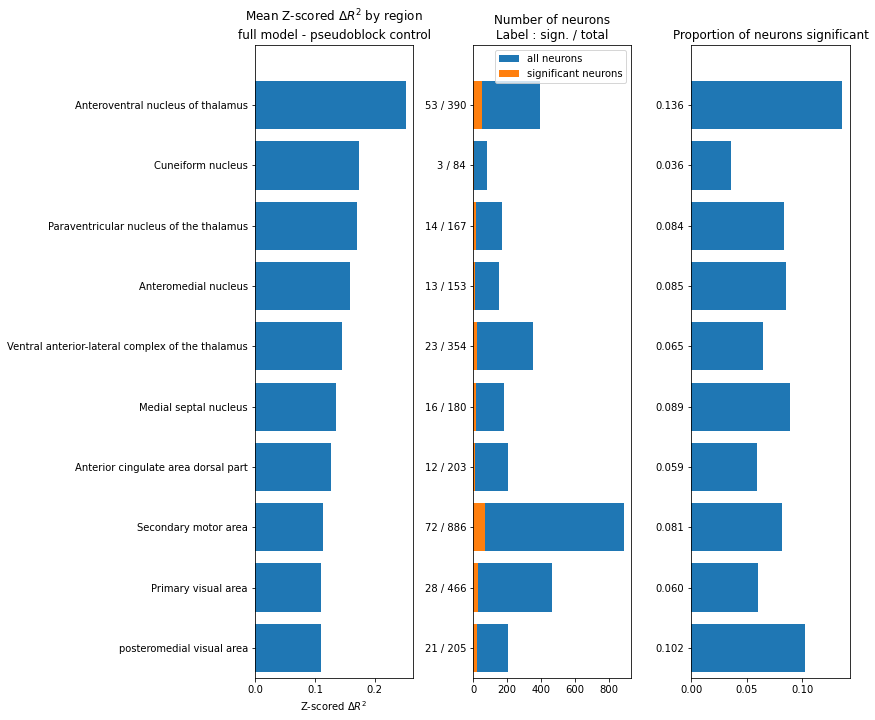

In [69]:

n_regions = 10
# topreg_melt = deltascores[np.isin(deltascores[grouper], topregions.index)]
fig, ax = plt.subplots(1, 3, figsize=(12, len(topregions) * 0.10))
# medians = topreg_melt.groupby(grouper).agg({'diff':'median'}).sort_values('diff', ascending=False)[:n_regions]
# means = topreg_melt.groupby(grouper).agg({'diff':'mean'}).sort_values('diff', ascending=False)[:n_regions]
zmeans = topreg_master.groupby(grouper).agg({'zsc':'mean'}).sort_values('zsc', ascending=False)[:n_regions]
order = zmeans.index
ax[0].barh(range(len(zmeans)), zmeans.values.flatten()[::-1], tick_label=zmeans.index[::-1])
ax[0].set_title('Mean Z-scored $\Delta R^2$ by region\nfull model - pseudoblock control')
ax[0].set_xlabel(r'Z-scored $\Delta R^2$')

nsig = masterscores.groupby(grouper).significant.sum().reindex(order)[::-1]
nneur = masterscores.name.value_counts().reindex(order)[::-1]
propsig = masterscores.groupby(grouper).significant.apply(lambda x: x.sum() / len(x)).reindex(order)[::-1]

ax[1].barh(range(len(zmeans)), nneur,
           label='all neurons')
ax[1].set_title('Number of neurons\nLabel : sign. / total')

ax[1].barh(range(len(zmeans)), nsig,
           label='significant neurons')
ax[1].legend()
ax[1].set_yticks(range(len(zmeans)))
ax[1].set_yticklabels([str(sig) + ' / ' + str(num) for sig, num in zip(nsig, nneur)])

ax[2].barh(range(len(zmeans)),
           propsig)
ax[2].set_title('Proportion of neurons significant')
ax[2].set_yticks(range(len(zmeans)))
ax[2].set_yticklabels([f'{p:0.3f}' for p in propsig])
for subax in ax:
    subax.set_ylim([-0.5, len(zmeans)])
plt.tight_layout()


Text(0.5, 1.0, 'Proportion of cells with full-model score above 95% of pseudoblock scores')

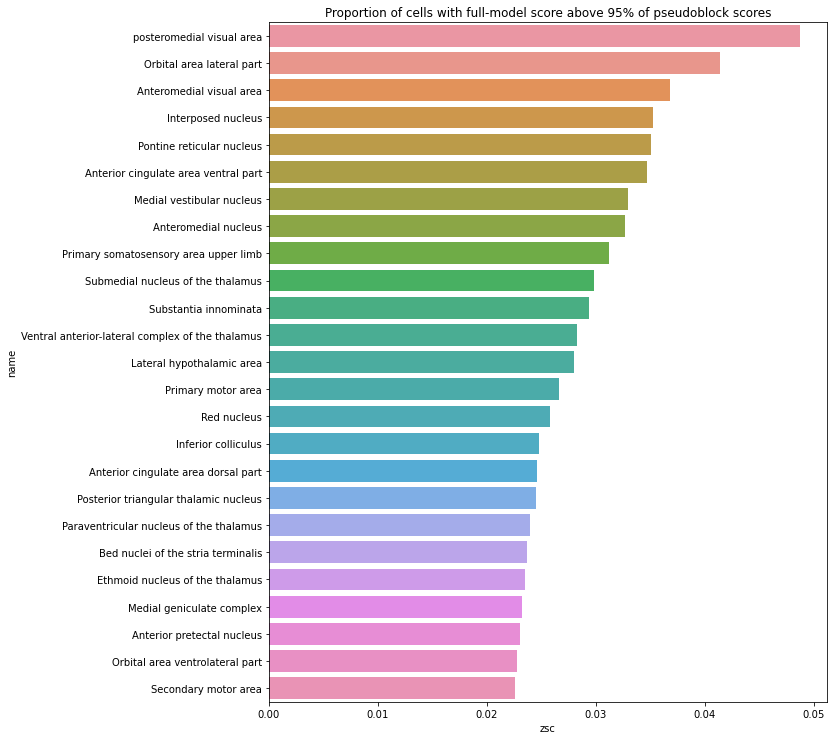

In [39]:
n_regions = 25
grpby = masterscores[np.isin(masterscores[grouper], topregions.index)].groupby(grouper)
sigprops = grpby.agg({'zsc': lambda sr: np.mean(sr > 1.6)}).sort_values('zsc', ascending=False)[:n_regions]
plt.figure(figsize=(10, n_regions * 0.5))
sns.barplot(x='zsc', y='name', data=sigprops.reset_index(), orient='h')
plt.title('Proportion of cells with full-model score above 95% of pseudoblock scores')

In [40]:
# diffs = short_medians - medians
# topdiffs = diffs.sort_values(by='value', ascending=False)
# topdiffs

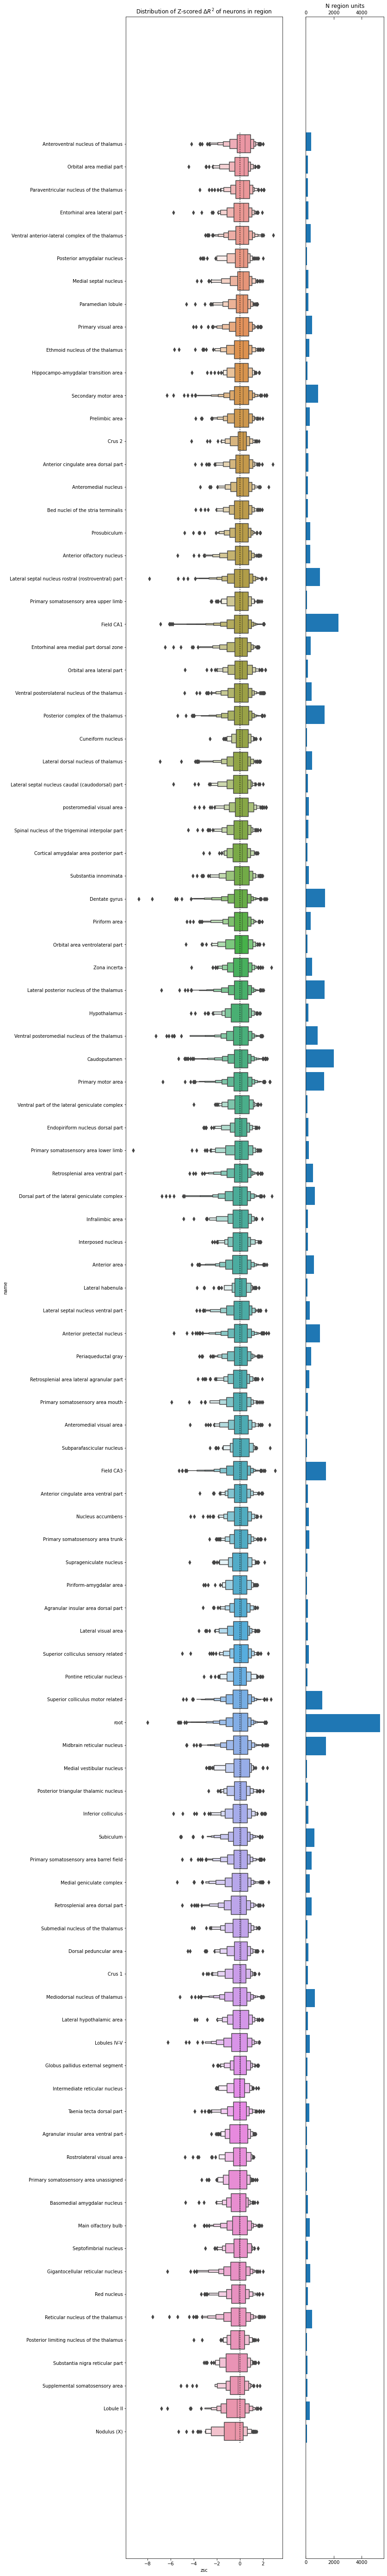

In [41]:
topreg_master = masterscores[np.isin(masterscores[grouper], topregions.index)]
regorder = topreg_master.groupby(grouper).agg({'zsc':'median'}).sort_values('zsc', ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(10, len(topregions)), gridspec_kw={'width_ratios': [2, 1]})
sns.boxenplot(data=topreg_master, x='zsc', y=grouper,
              order=regorder, ax=ax[0])
ax[0].vlines(0, ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='k', ls=':')
ax[0].set_title(r'Distribution of Z-scored $\Delta R^2$ of neurons in region')
# ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=45)

ax[1].barh(ax[0].get_yticks(), topreg_master[grouper].value_counts().loc[regorder].iloc[::-1])
ax[1].set_yticks([])
ax[1].set_title('N region units')
ax[1].tick_params(labeltop=True, top=True, direction='in', length=6)

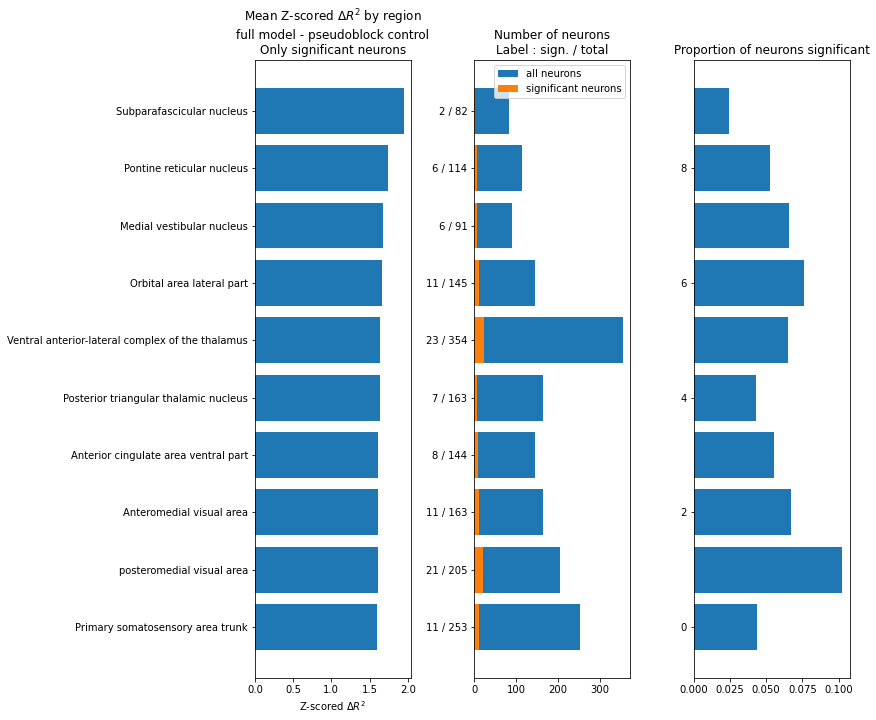

In [71]:
n_regions = 10
topreg = masterscores[np.isin(masterscores[grouper], topregions.index)]
topreg = topreg[topreg['significant']]
fig, ax = plt.subplots(1, 3, figsize=(12, len(topregions) * 0.10))
zmeans = topreg.groupby(grouper).agg({'zsc':'mean'}).sort_values('zsc', ascending=False)[:n_regions]
order = zmeans.index
ax[0].barh(range(len(zmeans)), zmeans.values.flatten()[::-1], tick_label=zmeans.index[::-1])
ax[0].set_title('Mean Z-scored $\Delta R^2$ by region\nfull model - pseudoblock control\nOnly significant neurons')
ax[0].set_xlabel(r'Z-scored $\Delta R^2$')

nsig = masterscores.groupby(grouper).significant.sum().reindex(order)[::-1]
nneur = masterscores.name.value_counts().reindex(order)[::-1]

ax[1].barh(range(len(zmeans)), nneur,
           label='all neurons')
ax[1].set_title('Number of neurons\nLabel : sign. / total')

ax[1].barh(range(len(zmeans)), nsig,
           label='significant neurons')
ax[1].legend()
ax[1].set_yticks(range(len(zmeans)))
ax[1].set_yticklabels([str(sig) + ' / ' + str(num) for sig, num in zip(nsig, nneur)])

ax[2].barh(range(len(zmeans)),
           masterscores.groupby(grouper).significant.apply(lambda x: x.sum() / len(x)).reindex(order)[::-1])
ax[2].set_title('Proportion of neurons significant')
plt.tight_layout()

In [74]:
%connect_info

{
  "shell_port": 47517,
  "iopub_port": 35979,
  "stdin_port": 41593,
  "control_port": 60649,
  "hb_port": 52669,
  "ip": "127.0.0.1",
  "key": "c6f11d12-298602f51fede7d38b330cd6",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-8235b72a-611b-4b31-a399-4f317dc8cd6b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
